# Tarea: Entendimiento de los datos con PySpark

## Configuración general

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np

path_jar_driver = '/home/wcpaez/Downloads/mysql.jar'

#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://**.**.**.**:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_39'
db_psswd = '************'

PATH='./'

def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

sql_movimientos = 'WWImportersTransactional.movimientosCopia'
#Se cargan el dataframes desde la BD
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

### Información dada por la organización relacionada con los datos
Para la tabla movimientosCopia, que registra el movimiento en inventario de un producto, el negocio menciona que:

- La cantidad máxima de productos movidos es 50 millones por viaje
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores

## Perfilamiento de datos

### Entendimiento general de los datos

Se genera una muestra de los datos de la tabla movimientos

In [11]:
movimientos.show(10)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

Como se puede observar en la tabla movimientos tenemos que se tiene información relacionada:

- La información del producto es su identificar _ProductoID_
- La información del tipo de transacción es _TipoTransaccionID_
- La información del cliente es _ClienteID_
- La información del proveedor es _ProveedorID_
- La información de la orden es _OrdenDeCompraID_

y la información de un movimiento es:

- El identificador del movimiento en _TransaccionProductoID_
- El identificador de la factura en _InvoiceID_
- La fecha que se realizó el movimiento en _FechaTransaccion_
- La cantidad movida en la columna _Cantidad_, salidas representadas con valor negativo, ingresos con valor positivo


Tambien se procede a evaluar el esquema para tener el tipo de dato de cada una:

In [12]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

Los tipos de datos estan distribuidos de la siguiente forma:
- Integer (TransaccionProductoID, ProductoID, TipoTransaccionID)
- Double (ClienteID, InvoiceID, Cantidad)
- String (ProveedorID, OrdenDeCompraID, FechaTransaccion)

Tambien se calcula el total de registros y columnas

In [13]:
print((movimientos.count(), len(movimientos.columns)))

(204292, 9)


**¿Cantidad de registros y cantidad de columnas por tipo de dato?**
En total tenemos 204.292 movimientos con 9 variables a revisar de las cuales 6 son nùmericas(3 Integer, 3 Double) y 3 de tipo String, cabe resaltar que la columna FechaTransaccion no esta representado como un tipo fecha.

**¿Qué es una fila de cada fuente compartida?**
Con estos análisis podemos concluir que una fila de movimientos representa la entrada y salida de productos a Wide Importers. Una salida tiene una cantidad negativa con un cliente y una factura. Un ingreso tiene una cantidad positiva, con un proveedor y una orden de compra.

### Revision de reglas de negocio

#### Regla: La cantidad máxima de productos movidos es 50 millones por viaje

Lo primero que vamos a calcular es el valor movido total por OrdenDeCompraID, esto representa un viaje de ingreso.

In [33]:
movimientos.where(col("OrdenDeCompraID") != "").groupBy("OrdenDeCompraID").sum("Cantidad").sort(col("sum(Cantidad)").desc()).show(1)

+---------------+-------------+
|OrdenDeCompraID|sum(Cantidad)|
+---------------+-------------+
|         2048.0|     320904.0|
+---------------+-------------+
only showing top 1 row



Como podemos ver el valor máximo de ingreso es 320904.0 para la orden con ID 2048. **Se cumple la regla de negocio**.

De la misma forma se evalua las salidas, vamos a agrupar por InvoiceID, esto representa un viaje de salida:    

In [37]:
movimientos.where(col("OrdenDeCompraID") == "").groupBy("InvoiceID").sum("Cantidad").sort(col("sum(Cantidad)").asc()).show(1)

+---------+-------------+
|InvoiceID|sum(Cantidad)|
+---------+-------------+
|  29796.0|      -1273.0|
+---------+-------------+
only showing top 1 row



En el caso de salidas se puede ver que el máximo movido es de 1273.0 de la factura 29796. **Se cumple la regla del negocio**.

**Consulta al negocio #1:**
Dado que no se tiene un concepto claro de lo que es un viaje, se desea saber si la forma de agrupar ya sea por OrdenDeCompraID(Ingresos) o por InvoiceID(salidas) es la representación correcta de un viaje. Se solicita aclarar este concepto.

#### Regla: Existen 236.668 movimientos de producto realizados desde 2013

Dado que en la tabla solo existen 204.292 registros esta regla de negocio **no** se cumple. Adicional se informa que es necesario transformar esta columna dado que al estar con un tipo de dato String no se puede realizar cálculos de fecha.

#### Regla: Los movimientos están relacionados con 228.265 clientes

Se procede a hacer el calculo de cuantos clientes distintos hay en la tabla movimientos.

In [50]:
movimientos.where("ClienteID IS NOT NULL").where(col('ClienteID') != 0).select(col('ClienteID')).distinct().count()

663

Esta regla de negocio **no** se cumple dado que solo hay 663 clientes distintos en la tabla movimientos.

**Consulta al negocio #2:**
Se ha observado que cuando existe un ingreso de productos(cantidad positiva), se registra en ClienteID el valor de 0. Queremos saber si debe ser considerado como cliente el ID 0. Se solicita aclarar este concepto.

#### Regla: El formato de fechas manejado es YYYY-MM-DD HH:MM:SS

In [41]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de movimientos: "+str(movimientos.count())+", número de movimientos con formato correcto: "+str(cumplenFormato.count()))

Número total de movimientos: 204292, número de movimientos con formato correcto: 140038


In [46]:
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show(1)

+----------------+
|FechaTransaccion|
+----------------+
|     Apr 25,2014|
+----------------+
only showing top 1 row



(64254, None)

Como se puede observar hay 64.254 registros que no cumplen con el formato dado. Esta regla de negocio **no** se cumple, es necesario hacer una transformación no solo de los formatos, sino también del tipo de dado de esta columna dado que es un String.

#### Regla: Actualmente tenemos 13 proveedores

In [48]:
movimientos.where("ProveedorID IS NOT NULL").where(col('ProveedorID') != "").select(col('ProveedorID')).distinct().count()

3

Esta regla de negocio **no** se cumple dado que solo hay 3 proveedores.

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Se realiza los estadisticos generales como conteo, mínimo, máximo, desviación estandar.
Para tener una mejor comprension de los datos, decidimos separar ingresos(cantidad positiva) de salidas(cantidad negativa)

#### Para movimientos de tipo ingreso

In [54]:
movimientos.where('Cantidad > 0').summary().show()

+-------+---------------------+------------------+-------------------+---------+---------+-----------------+------------------+--------------------+------------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|ClienteID|InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|          Cantidad|
+-------+---------------------+------------------+-------------------+---------+---------+-----------------+------------------+--------------------+------------------+
|  count|                 7129|              7129|               7129|     7129|     7129|             7129|              7129|                7129|              7129|
|   mean|   211909.66474961425|120.46458128769814| 11.002665170430635|      0.0|      0.0|4.951898734177215|1345.9973277074544|                null|21700.456024687894|
| stddev|    70963.66259008426|51.480212747637104|0.05156006402512745|      0.0|      0.0|1.406311225432683|420.37740964792835|                null|13593.400385

De estos datos podemos determinar que:
   - Hay 7129 registros de tipo ingreso.
   - No son importantes los campos ClienteID e InovoiceID al tener una media de 0. Esto nos da a entender que estas columnas no son usadas para un movimiento de tipo ingreso.
   - Las cantidades de ingreso van desde 1 hasta 67368 para un producto en específico. 
   - Al ver TipoTransaccionID, al tener una stddev muy cerca a cero, podemos determinar que casi todas los ingresos son de TipoTransaccionID 11(Stock Receipt)
   
Para verificar que tipos de transacciones se tiene se pasa a agrupar:


In [60]:
movimientos.where('Cantidad > 0').groupby("TipoTransaccionID").count().orderBy("count", ascending=False).show(5)

+-----------------+-----+
|TipoTransaccionID|count|
+-----------------+-----+
|               11| 7110|
|               12|   19|
+-----------------+-----+



Se confirma que la casi el total de movimientos de ingreso son de tipo 11. 

Para tener una visualización de como se distribuye las cantidades vemos  el siguiente diagrama de caja:

{'whiskers': [<matplotlib.lines.Line2D at 0x7f20a6f6b640>,
 'caps': [<matplotlib.lines.Line2D at 0x7f20a6f6bca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f20a6f6b310>],
 'medians': [<matplotlib.lines.Line2D at 0x7f20a7769400>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f20a77696d0>],
 'means': []}

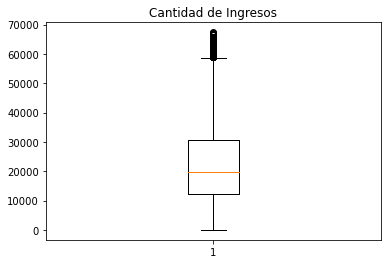

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de Ingresos')
ax1.boxplot(np.array(movimientos.where('Cantidad > 0').select('Cantidad').collect()))

Si bien la mayor parte de movimientos tiene una cantidad entre 10.000 y 30.000, también se puede ver que existen movimientos muy por encima del promedio. Esto también se verifica tambien al ver la stddev de 13593.4 para la cantidad.


#### Para movimientos de tipo salida

In [55]:
movimientos.where('Cantidad < 0').summary().show()

+-------+---------------------+------------------+--------------------+-----------------+------------------+-----------+---------------+--------------------+-------------------+
|summary|TransaccionProductoID|        ProductoID|   TipoTransaccionID|        ClienteID|         InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|           Cantidad|
+-------+---------------------+------------------+--------------------+-----------------+------------------+-----------+---------------+--------------------+-------------------+
|  count|               197158|            197158|              197158|           197158|            197158|     197158|         197158|              197158|             197158|
|   mean|   212479.65874070543|110.34856815346068|  10.000223171263656|536.0442842796133|44511.642738311406|       null|           null|                null|-39.128541575792006|
| stddev|    71365.98001145638|63.854648397177975|0.021125694912629004|345.6163685294113|14973.463033388263|  

De estos datos podemos determinar que:
   - Hay 197158 registros de tipo salida.
   - No son importantes los campos ProveedorID y OrdenDecompraID al no tener datos. Esto nos da a entender que estas columnas no son usadas para un movimiento de tipo salida.
   - Las cantidades de ingreso van desde 1 hasta 360 para un producto en específico. 
   - Al ver TipoTransaccionID, al tener una stddev muy cerca a cero, podemos determinar que casi todas los ingresos son de TipoTransaccionID 10(Stock Issue)


In [62]:
movimientos.where('Cantidad < 0').groupby("TipoTransaccionID").count().orderBy("count", ascending=False).show(5)

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               10|197136|
|               12|    22|
+-----------------+------+



Se confirma que la casi el total de movimientos de ingreso son de tipo 10.

## Análisis de calidad de datos

### Completitud

In [80]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        print(c, vacios)
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

In [ ]:
contar_vacios(movimientos)

Se detecta que todas las columnas no tienen valores nulos, pero ademas se procede a ver en las columnas de tipo string si no tienen valores vacios.

In [84]:
movimientos.where("ProveedorID = ''").count(), movimientos.where(" OrdenDeCompraID = ''").count(), movimientos.where("FechaTransaccion = ''").count()

(197182, 197182, 0)

Podemos ver que existen valores en las columnas ProveedorID y OrdenDeCompraID que estan vacios, pero esto debemos de evaluarlo en el marco de un salida dado que cuando se tiene un valor negativo estos campos pueden estar vacios.

In [86]:
movimientos.where("ProveedorID = '' AND Cantidad > 0").show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|               326934|        57|               12|      0.0|      0.0|           |               |         Apr 30,2016|     3.0|
|               326936|        51|               12|      0.0|      0.0|           |               |         Apr 30,2016|     1.0|
|               301420|       113|               12|      0.0|      0.0|           |               |         Jan 31,2016|     3.0|
|               146565|       175|               12|      0.0|      0.0|           |               |         Jul 31,2014|     2.0|
|                97777|        70|               12|      0.0|      0.0|           

Con esto descubrimos un tipo especial de movimiento, lo cual nos lleva a nuestra siguiente consulta.

**Consulta al negocio #3:**
Se necesita saber que significa un movimiento de TipoTransaccionID = 12, donde no se tiene referencia ni a un cliente, ni a una factura, ni a un proveedor ni a una orden.

### Unicidad

In [65]:
movimientos.count(), movimientos.distinct().count()

(204292, 173659)

Como se observa existen solo 173.659 registros únicos de 204.292. Vamos a ver si existen duplicados en la llave primaria TransaccionProductoID.

In [68]:
movimientos.groupBy("TransaccionProductoID").count().orderBy("count", ascending=False).show(5)

+---------------------+-----+
|TransaccionProductoID|count|
+---------------------+-----+
|               197953|    2|
|               323250|    2|
|               101055|    2|
|               309597|    2|
|               209326|    2|
+---------------------+-----+
only showing top 5 rows



In [69]:
movimientos.where("TransaccionProductoID = 197953").show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|               197953|       212|               10|    174.0|  41456.0|           |               |2015-02-12 12:00:...|   -10.0|
|               197953|       212|               10|    174.0|  41456.0|           |               |2015-02-12 12:00:...|   -10.0|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+



Existen duplicados de registros en su totalidad, se recomienda eliminar estos duplicados. Se tiene como máximo un duplicado por movimiento.

### Consistencia

Del analisis descriptivo anterior se sabe que casi todos los registros para un movimiento de salida es de TipoTransaccionID 10, mientras para ingreso el 11. Procedemos a ver estos datos:

In [70]:
obtener_dataframe_de_bd(db_connection_string, "WWImportersTransactional.TiposTransaccion", db_user, db_psswd).show()

+-----------------+---------------------+
|TipoTransaccionID|TipoTransaccionNombre|
+-----------------+---------------------+
|                2| Customer Credit Note|
|                3| Customer Payment ...|
|                4|      Customer Refund|
|                5|     Supplier Invoice|
|                6| Supplier Credit Note|
|                7| Supplier Payment ...|
|                8|      Supplier Refund|
|                9|       Stock Transfer|
|               10|          Stock Issue|
|               11|        Stock Receipt|
|               12| Stock Adjustment ...|
|               13|      Customer Contra|
+-----------------+---------------------+



Se procede a verificar estos valores y ambos representan un movimiento de stock, Stock Issue(ID 10), Stock Receipt(ID 11). Se cree que para una salida de material no deberia tener Stock Issue.

**Consulta al negocio #4:**
Se necesita saber si un movimiento de tipo salida puede tener de Tipo de Transaccion un valor de Stock Issue. Se solicita aclarar este concepto.

### Validez

En la columna FechaTransaccion no existe se cumple el formato de regla de negocio, existen datos con otro formato.

Se procede a verificar que los movimientos de salida, los que tienen InvoiceID y ClienteID solo pueden tener valores negativos.

In [74]:
movimientos.where("ClienteID IS NOT NULL AND InvoiceID IS NOT NULL AND cantidad < 0").count(), movimientos.where("cantidad < 0").count()

(197158, 197158)

Se procede a verificar que los movimientos de salida, los que tienen ProveedorID y OrdenDeCompraID solo pueden tener valores positivos.

In [75]:
movimientos.where("ProveedorID IS NOT NULL AND OrdenDeCompraID IS NOT NULL AND cantidad > 0").count(), movimientos.where("cantidad > 0").count()

(7129, 7129)

Dada la totalidad de registros (197158 + 7128) se da a conocer que no existen registros con cantidad de movimiento igual a 0.

### Conclusiones/resultados
#### Conclusiones generales:
- En la tabla de movimientos tenemos información relacionada al ingreso y salida de productos. 
- Dependiendo si es un ingreso o una salida se puede tener valores positivos o negativos en la columna cantidad. **¿Esto es correcto?**
- Existe una columna de llave foránea ClienteID que está con tipo Double, este debe ser cambiado a Integer.
- Existen  dos columnas de llave foránea ProveedorID y OrdenDecompraID que tienen como tipo String, estas deben ser cambiadas a Integer.
- La columna FechaTransaccion está representada con un tipo String, debe ser cambiada a tipo Fecha.
- Una fila de movimiento representa un movimiento de un producto, este debe tener los datos de cliente y factura en caso de ser una salidad, y tener los datos de proveedor y orden en caso de ser un ingreso. Los ingresos son representados con una cantidad positiva, las salidas con una cantidad negativa. **¿Es posible tener un movimiento sin referencias a cliente o proveedor?**
- Dado que no se tiene una tabla que referencia a las facturas, se desea saber si InvoiceID debe estar representado con un tipo double, o solo string.

#### Conclusiones de reglas de negocio:

- La regla 1 es cierta si manejamos el concepto de viaje como una agrupación de InvoiceID o OrdenDeCompraID, dependiendo si es un ingreso o una salida de material. **Se solicita al negocio aclarar el concepto de viaje.**
- La regla 2 no se cumple dado que solo existen 204.292 en total.
- La regla 3 no se cumple dado que solo existen 663 clientes. **Se necesita aclarar que significa un ClienteID y un InvoiceID igual a cero.**
- La regla 4 no se cumple dado que se tiene 64254 registros con formato incorrecto, así también un ordenamiento y filtro se restringe dado que esta columna es de tipo string.
- La regla 5 no se cumple dado que solo hay 3 proveedores.

#### Conclusiones de análisis descriptivo:

- Se debe separar movimientos de tipo salida y movimientos de tipo ingreso.
- Existen menos movimientos de tipo ingreso(7129) frente a tipo salida(197158)
- Para evaluar un ingreso no es necesario los campos de ClienteID e InvoiceID. **¿Esto es correcto?**
- La mayor parte de los movimientos de ingreso son de TipoTransaccionID 11(Stock Receipt)
- Para evaluar una salida no son importantes los campos ProveedorID y OrdenDeCompraID. **¿Esto es correcto?**
- ELa mayor parte de los movimientos de salida son de TipoTransaccionID 10(Stock Issue)

#### Conclusiones de calidad:

- Para evaluar la completitud de los datos se tienen que evaluar de forma diferente un movimiento de ingreso al de una una salida.. **¿Esto es correcto?**
- Para una salida no se debe considerar un problema tener valores nulos en ProveedorID y OrdenDeCompraID.. **¿Esto es correcto?**
- Existen 19 registros de movimientos que no tienen ni ClienteID, ni InvoiceID, ni ProveedorID, ni OrdenDeCompraID. Estos registros son de TipoTransaccionID = 12, **se pide al negocio aclarar estos datos.**. Luego de ver este caso se pide aclarar cuando una cantidad es positiva y cuando es negativa, tambien si esto depende del Tipo de Transaccion.
- Solo existen 173.359 registros únicos, existen duplicados.
- En un tipo de movimiento de tipo salida, casi todos los datos tienen como Tipo de transacción el valor de Stock ISSUE, este parece ser incorrecto, **se solicita al negocio aclarar esto.**
- Se procede a verificar que los movimientos de salida, los que tienen ProveedorID y OrdenDeCompraID solo pueden tener valores positivos. **¿Esto es correcto?**
- Se procede a verificar que los movimientos de salida, los que tienen InvoiceID y ClienteID sólo pueden tener valores negativos. **¿Esto es correcto?**
- No existen movimientos con cantidad igual a 0.


Para finalizar debemos aclarar que este análisis ha sido realizado en base a muchos supuestos que deben ser resueltos por el negocio. Sin estas aclaraciones es imposible realizar un futuro tablero de control.  Se necesita saber más sobre que rol cumple el tipo de transacción, su relación con tener una cantidad positiva o negativa. Así también se necesita saber cuales son los escenarios donde se tiene ClienteID, InvoiceID, ProveedorID, y OrdenDeCompraID. 